<h1>Numba-PM-SINTEL
</h1><br>


##Configuring notebook if it is run in google colab

In [1]:
colab = False
try:
  from google.colab import drive
  drive.mount("/content/gdrive")
  colab = True
  %cd '/content/gdrive/My Drive/python_projects/FYP'
except Exception:
  pass

##Importing necessary libraries

In [2]:
import numpy as np
from components.classes.NumbaPatchMatcher import Wrapper as m
from components.classes.SimpleProgressBar import SimpleProgressBar

from components.non_oo_entities import utils as u
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc
from components.classes.CSVExperimentLogger2 import CSVExperimentLogger2 as l
from components.classes.Metrix import Metrix as me
from components.classes.SintelReader import SintelReader
import math
import time
import glob

##Configuring and testing data generator

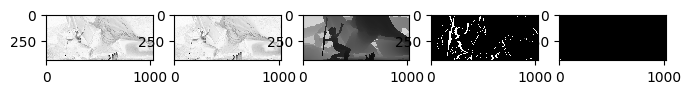

File ./optimization/final//numba_pm/pm_mixed_scanlines.csv already exists, header has not been written.


In [3]:
ROOT_DATA_SRC = "./optimization/final/"
LOG_DIRECTORY = ROOT_DATA_SRC+"/numba_pm/"
CSV_FILE_NAME =  "pm_mixed_scanlines.csv"
CSV_FILE_PATH = os.path.join(LOG_DIRECTORY, CSV_FILE_NAME)


path = "./datasets/sintel/training"
reader = SintelReader(rootPath=path)
#reader.print_available_scenes()
reader.set_selected_scene('cave_4')
loaded_imgs = reader.get_selected_scene_next_files()
SintelReader.plot_images_to_compare(loaded_imgs)

log = l(file_path = CSV_FILE_PATH)
progress_bar = SimpleProgressBar.get_instance()

##Matcher visual and metrical testing

> Indented block



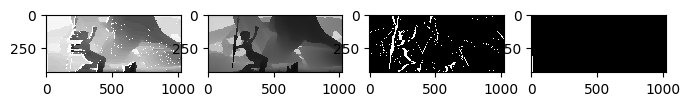

[148.25847324756307, 24871.895581726632, 105377.44535240925]


In [4]:
m_score, gap_score, egap_score = 60*3, -20*3, -1*3
matcher = m(m_score, gap_score, egap_score)
    
matcher.set_images(loaded_imgs[1], loaded_imgs[0])  
matcher.configure_instance()      
x,raw_disp_map = matcher.run_pipeline()

SintelReader.plot_images_to_compare([raw_disp_map, loaded_imgs[2], loaded_imgs[3], loaded_imgs[4]])

disp_modified = SintelReader.add_masks_to_raw_disparity(loaded_imgs[2],loaded_imgs[3], loaded_imgs[4])
ABS_ERR = me.avgerr(raw_disp_map, disp_modified)
mse = me.mse(raw_disp_map, disp_modified)
euclid = me.eucledian_distance(raw_disp_map, disp_modified)

print([ABS_ERR, mse, euclid])

##Initialising loop parameters

In [5]:
ORIGINAL_IMG_DIM = loaded_imgs[0].shape
STARTING_ROW_FOR_SLICES = 0
ROW_HEIGHT_PER_SLICE = 120
NUMBER_OF_COLUMNS = int(ORIGINAL_IMG_DIM[1]/2)
SCENES = reader.get_available_scenes()


SLICE_DIM = [ROW_HEIGHT_PER_SLICE, NUMBER_OF_COLUMNS]
main_temp = []
for i in range(len(SCENES)):
  reader.set_selected_scene(SCENES[i])
  temp = reader.get_selected_scene_next_sliced(SLICE_DIM, starting_row = 0)
  temp = np.array(temp)
  main_temp.append(temp)

stacked_imgs = np.hstack(main_temp)

(5, 2760, 512)


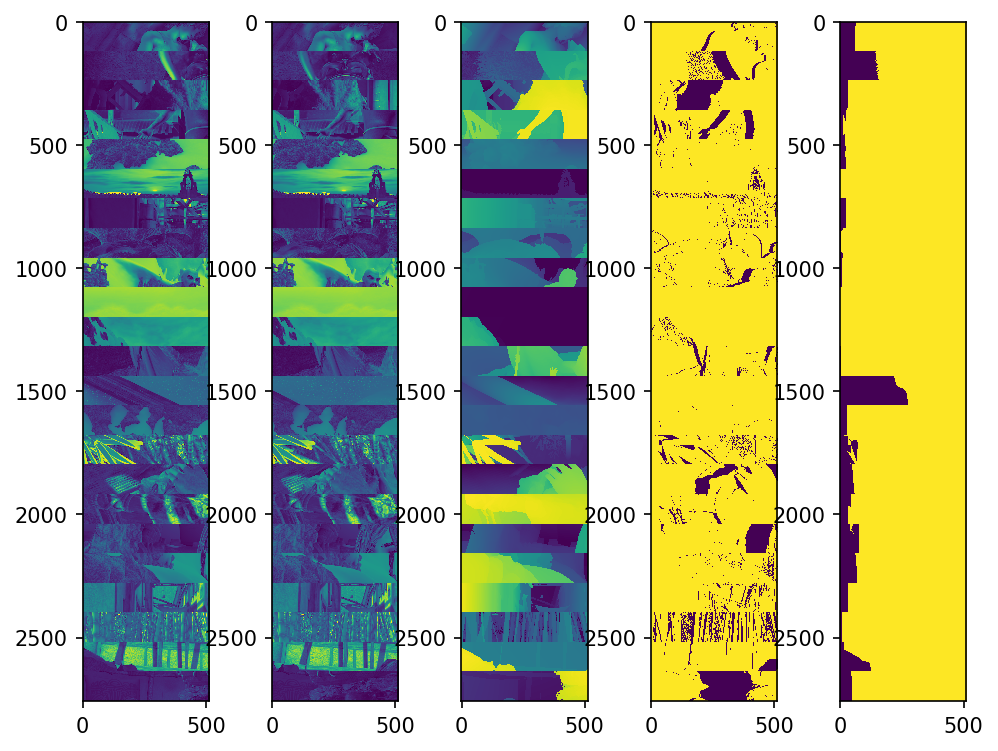

In [6]:
print(stacked_imgs.shape)
plt.figure(figsize = [8,6], dpi=150)
plt.subplots_adjust(wspace=0.1)
plt.subplot(151)
plt.imshow(stacked_imgs[0])
plt.subplot(152)
plt.imshow(stacked_imgs[1])
plt.subplot(153)
plt.imshow(stacked_imgs[2])
plt.subplot(154)
plt.imshow(stacked_imgs[3])
plt.subplot(155)
plt.imshow(stacked_imgs[4])
plt.show()

In [7]:
test_matcher = m(60*3, -20*3, -1*3)
test_matcher.configure_instance_for_optimisation()
test_matcher.set_images(stacked_imgs[1], stacked_imgs[0])
x = %time x, disp = test_matcher.run_pipeline()


CPU times: user 57min 24s, sys: 11.9 s, total: 57min 36s
Wall time: 1min 43s


(920, 512)
(920, 512)
68.28537279211956


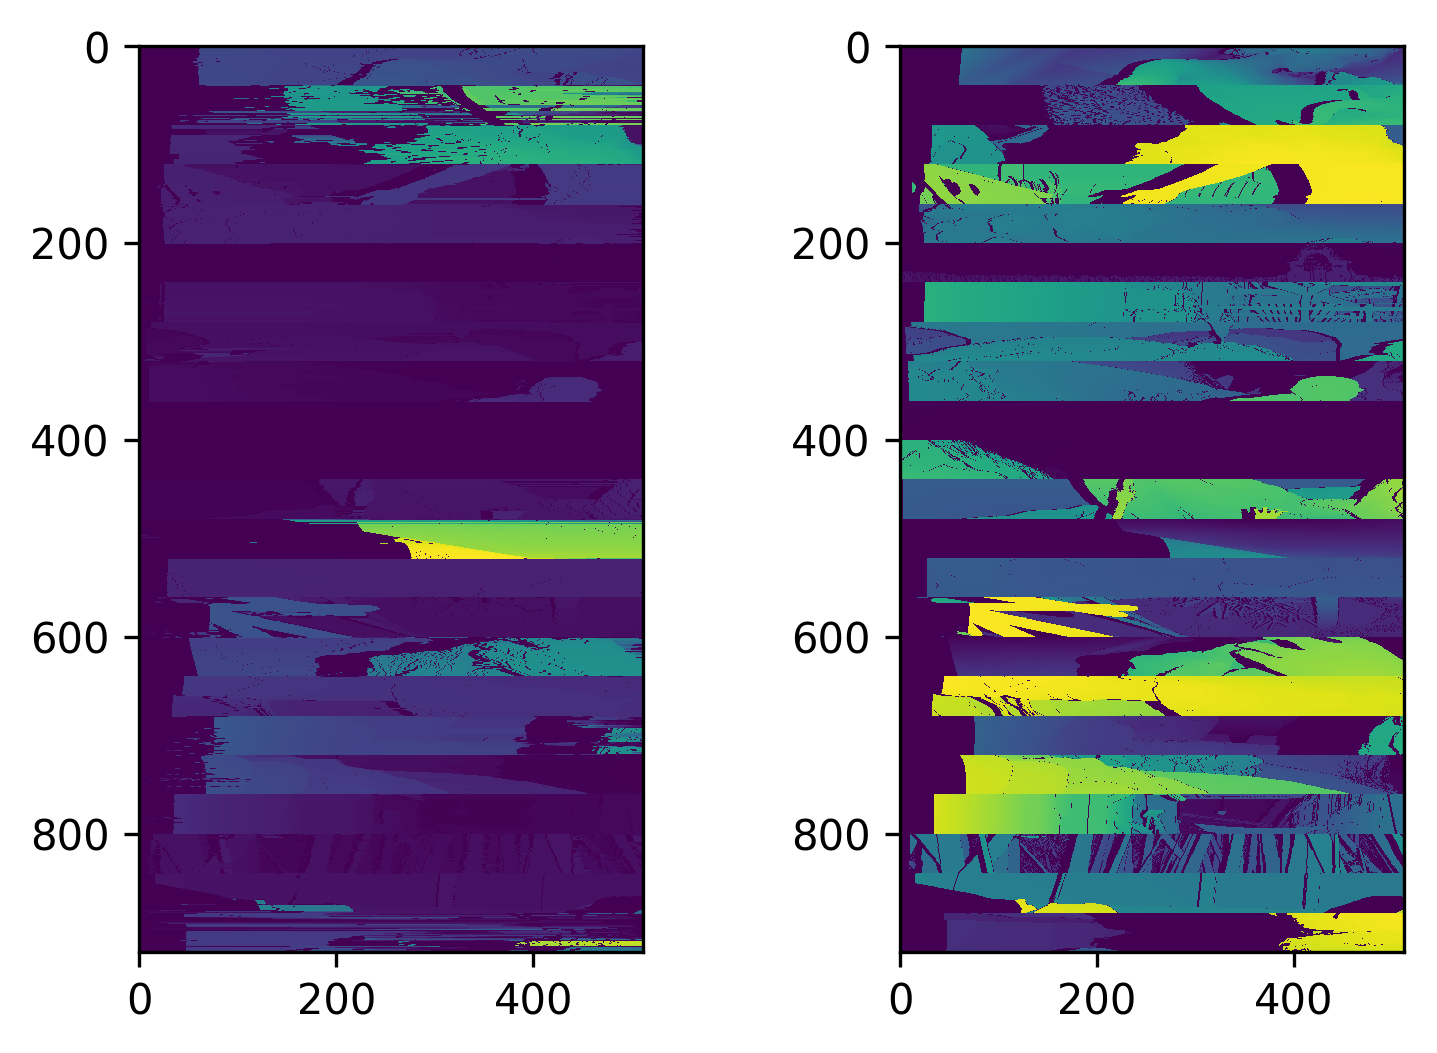

In [8]:
gt = reader.add_masks_to_raw_disparity(stacked_imgs[2], stacked_imgs[3], stacked_imgs[4])
gt = gt[1::3, :]
print(disp.shape)
print(gt.shape)
plt.figure(dpi=300)
plt.subplot(121)
plt.imshow(disp)
plt.subplot(122)
plt.imshow(gt)
print(me.avgerr(disp, gt))

In [9]:
import pandas as pd
temp_path = "./optimization/final/numba_legacy/legacy_mixed_lines.csv"
results_data_frame = pd.read_csv(temp_path)
results_data_frame.columns = [str.strip(col) for col in results_data_frame.columns]

results_data_frame.describe()


,match,gap,egap,matrix_init_mode,runtime,euclid_distance,mse,ABS_ERR
count,1760.000000,1760.000000,1760.000000,1760.0,1760.000000,1760.000000,1760.000000,1760.000000
mean,75.000000,-45.000000,-40.000000,2.0,20.167556,40351.744597,13859.730032,94.086499
std,46.110824,28.730977,31.631764,0.0,0.244460,1964.868976,1411.572178,5.112703
min,0.000000,-90.000000,-90.000000,2.0,19.054626,37361.034515,11853.319463,85.450280
25%,37.500000,-70.000000,-70.000000,2.0,20.104191,39448.640176,13214.972928,92.250425
50%,75.000000,-45.000000,-40.000000,2.0,20.180402,40127.836761,13673.940931,93.515065
75%,112.500000,-20.000000,-10.000000,2.0,20.239465,40646.372078,14029.615869,94.600760
max,150.000000,0.000000,10.000000,2.0,22.554628,50147.851499,21355.358441,115.212458


In [10]:
top5_config = []

selected_metric = "ABS_ERR"
res = results_data_frame.sort_values(by=selected_metric).head(10)
res = res[["match", "gap", "egap", selected_metric]].values
top5_config.append(res)

selected_metric = "mse"
res = results_data_frame.sort_values(by=selected_metric).head(10)
res = res[["match", "gap", "egap", selected_metric]].values
top5_config.append(res)

selected_metric = "euclid_distance"
res = results_data_frame.sort_values(by=selected_metric).head(10)
res = res[["match", "gap", "egap", selected_metric]].values
top5_config.append(res)
top5_config.append([60, -20, -1, 0])
stacked = np.vstack(top5_config)
print(stacked.shape[0])
print("Please enter the estimated runtime per images in seconds below:")
runtime_multiplyer = input()

31
Please enter the estimated runtime per images in seconds below:


 103


In [11]:
spec_dict = dict({})
spec_dict["is_parallel"] = "True"
spec_dict["img_name"] = "sintel_pm_920_256"
spec_dict["alg_type"] =  "pm_numba_matcher_stacked"
spec_dict["is_img_preprocessed"] = "False"
spec_dict["convolution_filters"] = "-"
spec_dict["filter_strategy"] = "-"
spec_dict["matching_mode"] = non_occ =  "occlusions_added_to_the_groundtruth"
spec_dict["matrix_init_mode"] = 2

multiplyers = [2,3,4,5]
number_of_iterations = 1

number_of_iterations =number_of_iterations * len(multiplyers) * stacked.shape[0]
est_runtime = int(number_of_iterations) * int(runtime_multiplyer)

print("The number of iterations based on the params: {0}".format(round(number_of_iterations)))
print("The amount of time (s) needed to perform the parameter search: {0}".format(est_runtime))
print("The amount of time (h) needed to perform the parameter search: {0}".format(est_runtime/3600))

The number of iterations based on the params: 124
The amount of time (s) needed to perform the parameter search: 12772
The amount of time (h) needed to perform the parameter search: 3.5477777777777777


In [12]:
import importlib
from components.classes import NumbaPatchMatcher
importlib.reload(NumbaPatchMatcher)

<module 'components.classes.NumbaPatchMatcher' from '/home/jupyter/FYP/components/classes/NumbaPatchMatcher.py'>

##Running the optimisation

In [13]:
progress_counter = 1
start_time = time.time()
for multi in multiplyers:
    for best_params in stacked:
      spec_dict["matrix_init_mode"] = 2
    
      match = spec_dict["match"] = best_params[0]*multi
      gap = spec_dict["gap"] = best_params[1]*multi
      egap = spec_dict["egap"] = best_params[2]*multi
        
      matcher = NumbaPatchMatcher.Wrapper(match, gap, egap)
    
      matcher.set_images(stacked_imgs[1], stacked_imgs[0])
      matcher.configure_instance_for_optimisation()     
      tic=time.time()
      x,raw_disp_map = matcher.run_pipeline()
      toc = time.time()
      spec_dict["runtime"] = toc-tic
      spec_dict["filter_strategy"] = "multiplyer: "+str(multi)
      spec_dict["mse"] = me.mse(raw_disp_map, gt)
      spec_dict["euclid_distance"] =me.eucledian_distance(raw_disp_map, gt)
      spec_dict["ABS_ERR"] = me.avgerr(raw_disp_map, gt, print=False)
      progress_bar.progress_bar(progress_counter, number_of_iterations, header= "Parameter search progress: ", progress_bar_steps=100)
      progress_counter+=1
      log.append_new_sm_results(spec_dict)
end_time = time.time()

Parameter search progress:  [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00 % completed: 124 / 124 steps

In [17]:
print("The optimisation process taken {0} seconds or {1} hours".format((end_time-start_time), (end_time-start_time)/3600))

The optimisation process taken 12169.978833198547 seconds or 3.3805496758884854 hours
